In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [8]:
import os

results_path = "/home/jason/Applications/omnetpp-6.0.1/samples/florasat/simulations/satellitewired/results"
sca_files = [f for f in os.listdir(results_path) if "N=" in f and f.endswith(".vec")]

dfs_RESSIOT = []
dfs_DQ = []
for file_name in sca_files:
    os.system(f"opp_scavetool x {os.path.join(results_path, file_name)} -o {file_name}.csv")

    df = pd.read_csv(f"{file_name}.csv")
    if "RESSIoT" in file_name:
        dfs_RESSIOT.append(df)
    else:
        dfs_DQ.append(df)

dfs_RESSIOT.sort(key=lambda df: int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0]))
dfs_DQ.sort(key=lambda df: int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0]))

Exported 5025 vectors
Exported 525 vectors
Exported 25 vectors
Exported 564 vectors
Exported 275 vectors
Exported 1275 vectors
Exported 75 vectors
Exported 50027 vectors
Exported 10030 vectors
Exported 1060 vectors
Exported 148 vectors
Exported 5046 vectors
Exported 125 vectors
Exported 2540 vectors
Exported 262 vectors
Exported 5032 vectors


opp_scavetool: Index file (.vci) for "/home/jason/Applications/omnetpp-6.0.1/samples/florasat/simulations/satellitewired/results/General-RESSIoTSatelliteMac,RESSIoTNodeMac,N=5000-#0.vec" is out of date


AttributeError: 'DataFrame' object has no attribute 'value'

In [4]:
def get_throughput_bytes_per_hour(df):
    # Throughput B / hr
    sim_time_hours = float(df.loc[df['name'] == 'simulated time'].value.iloc[0]) / 60 / 60
    bytes_per_data_packet = int(df.loc[df['name'] == 'dataPacketLengthBits'].value.iloc[0]) / 8
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return (num_data_packets * bytes_per_data_packet) / sim_time_hours

def get_jfi(df):
    # Jain's Fairness Index
    num_nodes = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
    denominator = num_nodes * df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).pow(2).sum()
    numerator =  df[df['name'].str.startswith('numDataPacketsReceivedByNodeId', na=False)].value.astype(int).sum() ** 2.0
    jfi = numerator / denominator if denominator != 0 else 0
    return jfi

def get_overhead_bytes(df):
    # Total bytes of overhead (Beacon, RTS, VCTS) or (ARS, FBP)
    possible_keys = [
        ('numARSPacketsSent', 'arsPacketLengthBits'),
        ('numFBPPacketsSent', 'fbpPacketLengthBits'),
        ('numRTSPacketsSent', 'rtsPacketLengthBits'),
        ('numBeaconPacketsSent', 'beaconPacketLengthBits'),
        ('numVCTSPacketsSent', 'vctsPacketLengthBits'),
    ]
    
    overhead_bits = 0
    for key in possible_keys:
        try:
            total_num_packets = df.loc[df['name'] == key[0]].value.astype(int).sum()
            bits_per_packet = int(df.loc[df['name'] == key[1]].value.iloc[0])
            overhead_bits += (total_num_packets * bits_per_packet)
        except IndexError:
            pass

    return overhead_bits / 8

def get_data_bytes(df):
    bits_per_data_packet = int(df.loc[df['name'] == 'dataPacketLengthBits'].value.iloc[0])
    num_data_packets = int(df.loc[df['name'] == 'numDataPacketsReceived'].value.iloc[0])

    return bits_per_data_packet * num_data_packets / 8

{'DQ': {10: {'Data': 4500.0,
             'Jain Fairness Index': 0.8,
             'Overhead': 21937.5,
             'Throughput [bytes / hour]': 53357.916817285855},
        20: {'Data': 4500.0,
             'Jain Fairness Index': 0.7578947368421053,
             'Overhead': 28875.0,
             'Throughput [bytes / hour]': 53455.71155118384},
        50: {'Data': 4500.0,
             'Jain Fairness Index': 0.3031578947368421,
             'Overhead': 47250.0,
             'Throughput [bytes / hour]': 53271.208063058126},
        100: {'Data': 3750.0,
              'Jain Fairness Index': 0.14285714285714285,
              'Overhead': 79500.0,
              'Throughput [bytes / hour]': 44356.25509374915},
        250: {'Data': 1125.0,
              'Jain Fairness Index': 0.024,
              'Overhead': 187500.0,
              'Throughput [bytes / hour]': 13284.767783562036},
        500: {'Data': 375.0,
              'Jain Fairness Index': 0.004,
              'Overhead': 306375.0,
 

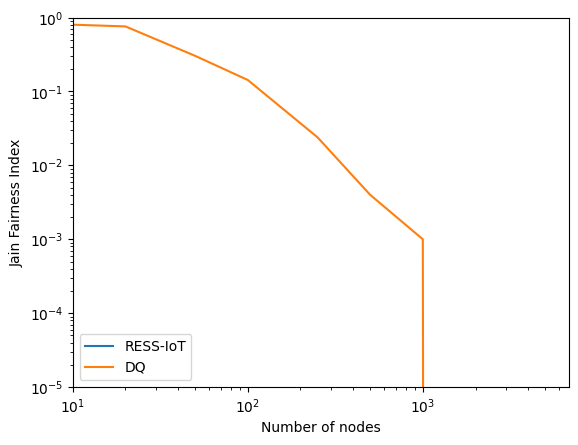

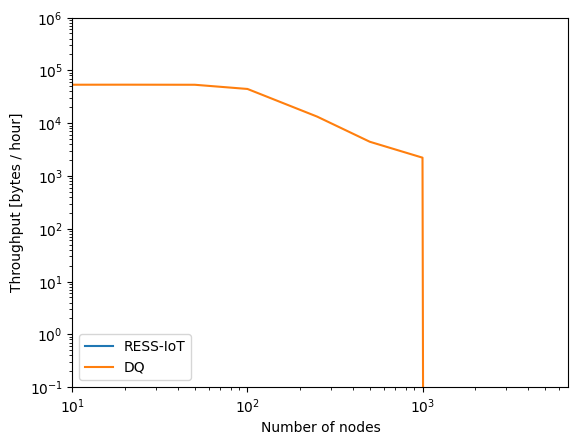

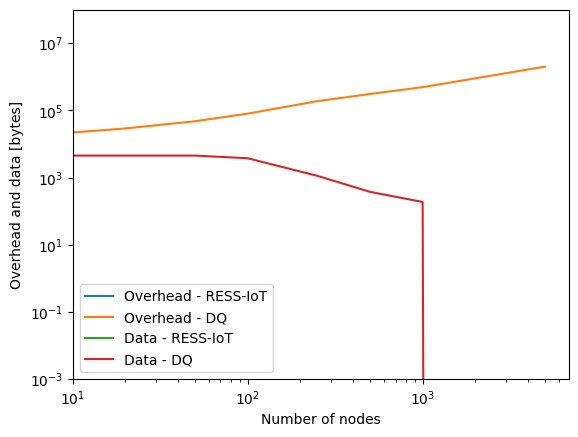

In [5]:
metrics = {};

protocol_keys = [("RESS-IoT", dfs_RESSIOT), ("DQ", dfs_DQ)]
for (key, dfs) in protocol_keys:
    metrics[key] = {}
    
    for df in dfs:
        node_count = int(df.loc[df['name'] == 'nrOfNodes'].value.iloc[0])
        metrics[key][node_count] = {
            "Jain Fairness Index": get_jfi(df),
            "Throughput [bytes / hour]": get_throughput_bytes_per_hour(df),
            "Overhead": get_overhead_bytes(df),
            "Data": get_data_bytes(df),
        }

pprint.pprint(metrics)


##### Jain Fairness Index
metric = "Jain Fairness Index"

for (key, _) in protocol_keys:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.00001, 1)
plt.xlim(xmin=10)
plt.show()

##### Throughput bytes / hour
metric = "Throughput [bytes / hour]"

for (key, _) in protocol_keys:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=key)

plt.ylabel(metric)
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.1, 1000000)
plt.xlim(xmin=10)
plt.show()

##### Overhead and data [bytes]
metric = "Overhead"

for (key, _) in protocol_keys:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=f"{metric} - {key}")
    
metric = "Data"

for (key, _) in protocol_keys:
    x = metrics[key].keys()
    y = [metrics[key][node_count][metric] for node_count in x]
    plt.plot(x, y, label=f"{metric} - {key}")

plt.ylabel("Overhead and data [bytes]")
plt.xlabel("Number of nodes")
plt.legend(loc="lower left")
plt.yscale("log")  
plt.xscale("log")  
plt.ylim(0.001, 100000000)
plt.xlim(xmin=10)
plt.show()